In [1]:
import pymysql
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import time

In [2]:
def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
    '''
    parameters: match_id: int

    returns:    ts_match_start, ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
    '''
    # get map start and end time
    path = 'D:\owl-data\pickles'
    file_name = 'OWL_map_start_info'
    timestamps = pd.read_pickle(os.path.join(path, file_name))

    # send error msg if there is no match_id
    if timestamps['esports_match_id'].isin([match_id]).any() == False:
        raise ValueError('there is no match_id in OWL_map_start_info')

    timestamps = timestamps[timestamps['esports_match_id'] == match_id]
    timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
    ts_match_start = timestamps['time_gamestart'].min()

    ts_map_start = timestamps['time_gamestart']
    ts_map_start.reset_index(drop=True, inplace=True)
    ts_map_end = timestamps['time_gameresult']
    ts_map_end.reset_index(drop=True, inplace=True)
    
    return ts_match_start, ts_map_start, ts_map_end

In [3]:
def get_team_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    team_one_name, team_one_id, team_two_name, team_two_id (str, int, str, int)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['team_one_name', 'team_two_name']]
    match_results.reset_index(inplace=True)
    team_one_name = match_results.loc[0, 'team_one_name']
    team_two_name = match_results.loc[0, 'team_two_name']
    
    # get team_ids
    esports_team_id = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'df_esports_team_id.pickle'))
    team_one_id = int(esports_team_id[esports_team_id['team_name'] == team_one_name]['team_id'])
    team_two_id = int(esports_team_id[esports_team_id['team_name'] == team_two_name]['team_id'])

    return team_one_name, team_one_id, team_two_name, team_two_id

In [4]:
def get_map_info(match_id=None):
    '''
    parameters: match_id: int

    returns:    map names (series)
    '''
    # get team_names
    path = 'D:\owl-data'
    file_name = 'OWL_match_results.csv'
    match_results = pd.read_csv(os.path.join(path, file_name))
    match_results = match_results[match_results['esports_match_id'] == match_id][['map_name']]
    match_results.reset_index(inplace=True)
    map_names = match_results['map_name']
    
    return map_names

In [5]:
# Get event timestamps
def getEvents(match_id=None, ssg=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # table names from mysql db
    db_name = 'esd_phs'

    # send query
    table_id = f'match_{match_id}'

    if team_id == 0: # default
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' ORDER BY `time`;"
    else: # where designated team_id
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' AND `esports_team_id` = '{team_id}' ORDER BY `time`;"

    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time in ms
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)

    # get map start times and end times
    map_start_times = ts_map_start - ts_match_start # set match start time as 0
    map_end_times = ts_map_end - ts_match_start # set match start time as 0

    # groupby df
    df2 = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    df2['time'] = pd.to_numeric(df2['time'])
    df2['time'] = df2['time'] / 1000 # ms to s
    df2['time'] = df2['time'] - ts_match_start # set match start time as 0

    sum_df = df2.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps
    
    sum_df = sum_df.droplevel(level='short_stat_guid')
    sum_df = sum_df.reset_index(level='time')
    sum_df['dx'] = sum_df['amount'].diff()
    sum_df['dt'] = sum_df['time'].diff()
    sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
    
    # define event time with threshold
    sum_df['event'] = sum_df['dx'] > threshold # True if dx > threshold
    
    # transform time (int) into UTC datetime
    sum_df['time'] += ts_match_start
    sum_df['time'] = pd.to_datetime(sum_df['time'], unit='s', utc=True)
    
    # resample
    # sum_df = sum_df.resample(interval, on='time').sum()

    return sum_df

In [6]:
def getEvents_alives(match_id=None, team_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)
                interval: '2S' (str), time interval to resample the data

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    events_lives = getEvents(match_id=match_id, ssg=1136, team_id=team_id)
    events_deaths = getEvents(match_id=match_id, ssg=41, team_id=team_id)
    events_alives = events_lives.merge(events_deaths, how='outer', on='time')
    events_alives['amount_y'].fillna(0, inplace=True)
    events_alives['amount'] = events_alives['amount_x'] - events_alives['amount_y']
    events_alives = events_alives[['time', 'amount']]
    
    return events_alives

In [7]:
def getEvents_teampowerbalance(match_id=None, stat_lifespan='ROUND', target_hero='no match'):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}

    returns:    events_teampowerbalance (pandas.DataFrame[['time', 'amount_{team_one}', 'amount_{team_two}', 'TPB']])
    '''
    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)

    team_one_alives = getEvents_alives(match_id=match_id, team_id=team_one_id)
    team_two_alives = getEvents_alives(match_id=match_id, team_id=team_two_id)
    events_teampowerbalance = team_one_alives.merge(team_two_alives, how='outer', on='time', suffixes=(f'_{team_one_name}', f'_{team_two_name}'))
    events_teampowerbalance['TPB'] = (events_teampowerbalance[f'amount_{team_one_name}'] * events_teampowerbalance[f'amount_{team_one_name}']) - (events_teampowerbalance[f'amount_{team_two_name}'] * events_teampowerbalance[f'amount_{team_two_name}'])

    return events_teampowerbalance

In [8]:
def getEvents_finalblows(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 44

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [9]:
def getEvents_herodamagedone(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=400):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 400 (float)

    returns:    event_alldamagedone (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 1208 # Hero_Damage_Done

    # get df
    sum_df = getEvents(match_id=match_id, ssg=ssg, stat_lifespan=stat_lifespan, target_hero=target_hero, team_id=team_id, threshold=threshold)

    return sum_df

In [10]:
def to_datetime(time):
    '''
    parameters: time: UTC timestamp in second(int)

    returns:    pd. datetime in seconds, UTC
    '''
    t = pd.to_datetime(time, unit='s', utc=True)

    return t

In [11]:
# TF detector
def TF_detector(df_rolling):
    '''
    parameters: dataframe
    <시작 조건>
    시작 조건 0. TF 중 = False
    시작 조건 1. time > 이전 TF 종료 시간
    시작 조건 2. HDD >= {HDD_threshold=500} (time - )
    시작 조건 3. FB > 0, time - {possible_time_variance=1}
    시작 조건 4. HDD >= {HDD_threshold=500} 시간 이후, first FB=False 상태로 HDD < {HDD_lull_cut=50} 생기면 이전 HDD time 제외

    <종료 조건>
    종료 조건 0. TF 진행 중 = True
    종료 조건 1. FB = 0 이 {no_FB_duration=10}초 이상
    종료 조건 2. time = ts_map_end_time

    *stagger
    *길어지는 한타
    FB 0 되고 10s동안 추가 킬이 없어야 한타 종료로 인정

    return:     TF_timestamps: dataframe of [['match_id', 'map_num', 'TF_start_time_stamps', 'TF_end_time_stamps']]
    '''
    global is_TF_ongoing
    is_TF_ongoing = False
    global FB_happened
    FB_happened = False
    global FB_silence
    FB_silence = False

    TF_start_time_stamps = []
    TF_end_time_stamps = []

    HDD_threshold = 500
    HDD_lull_cut = 200
    FB_threshold = 0
    possible_time_variance = 2
    no_FB_duration = 10

    # start condition
    def TF_start(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence
        
        def condition0(): # TF 중 = False
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = False
            else:
                cond0 = True
            return cond0

        def condition1(idx): # time > 이전 TF 종료 시간
            if (idx < df_rolling.index[-1]) == True:
                cond1 = True
            else:
                cond1 = False
            return cond1

        def condition2(idx): # HDD >= {HDD_threshold}
            if df_rolling.loc[idx, 'HDD'] > HDD_threshold:
                cond2 = True
            else:
                cond2 = False
            return cond2 
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # HDD가 오르는 추세에 있어야
            if (df_rolling.loc[idx - pd.to_timedelta(no_FB_duration, unit='s') : idx, 'HDD'].mean() <= df_rolling.loc[idx : idx + pd.to_timedelta(no_FB_duration, unit='s'), 'HDD'].mean()) == True:
                cond4 = True
            else:
                cond4 = False
            return cond4 
        
        def condition5(idx): # HDD 가 {no_FB_duration} 범위에서 최소값일 경우
            if (df_rolling.loc[idx, 'HDD'] <= df_rolling.loc[idx : idx + pd.to_timedelta(no_FB_duration, unit='s'), 'HDD'].min()) == True:
                cond5 = True
            else:
                cond5 = False
            return cond5 


        # check if start_condition == True
        start_condition = condition0() & condition1(idx) & ( (condition2(idx) & condition4(idx) & condition5(idx)) | condition3(idx) ) 
        
        if start_condition == True:
            is_TF_ongoing = True # toggle on
            FB_silence = False # toggle off

        return is_TF_ongoing
    
    # end condition
    def TF_end(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence

        def condition0(): # TF 진행 중 = True
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = True
            else:
                cond0 = False 
            return cond0

        def condition1(idx): # FB = 0 이 {no_FB_duration}초 이상 유지될 때
            global FB_silence
            if df_rolling.loc[idx: idx + pd.to_timedelta(no_FB_duration, unit='s'), 'FB'].sum() == 0:
                cond1 = True 
                FB_silence = True # toggle on
            else:
                cond1 = False
            return cond1 
        
        def condition2(idx): # time = ts_map_end_time (Map이 종료됐을 때)
            if idx == df_rolling.index[-1]:
                cond2 = True
            else:
                cond2 = False
            return cond2
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # while FB ==0 & HDD <= {HDD_lull_cut}
            if (df_rolling.loc[idx, 'FB'] == 0) & (df_rolling.loc[idx, 'HDD'] <= HDD_lull_cut):
                cond4 = True
            else:
                cond4 = False
            return cond4

        # init FB_happened
        condition3(idx)

        # check if end_condition == True
        end_condition = ( condition0() & (condition1(idx) & FB_happened) | (FB_happened & condition4(idx)) ) | condition2(idx)

        if end_condition == True:
            is_TF_ongoing = False # toggle off
            FB_happened = False # toggle off

        return is_TF_ongoing

    TF_status = []

    for idx in df_rolling.index:
        if is_TF_ongoing == False:
            TF_status.append(TF_start(idx))
        else:
            TF_status.append(TF_end(idx))

    df_rolling['TF_status'] = TF_status

    return df_rolling # [['TPB', 'HDD', 'FB', 'TF_status']], index=UTC timestamp

In [12]:
# get TF_time_range
def get_true_range(df=None, column='TF_status'):
    '''
    parameters: data: dataframe with timestamp index
                column: target column to arrange
    
    returns:    index tuple
    '''
    range_list = []
    prev_val = False

    for inx, val in df[column].iteritems():
        if prev_val != val:
            if val:
                start = inx
            else:
                range_list.append((start, inx))

        prev_inx = inx
        prev_val = val
    
    return range_list

In [13]:
def get_esports_match_ids(team_name='All', opponent_name='All', winner='All', loser='All', season='All', map_name='All'):
    '''
    parameters: team_name: target team name
                opponent_name: opponent team name
                winner: winner team name
                loser: loser team name
                season: 2018, 2019, 2020
                map: map name
                period: datetime range e.g.('2020-08-01':'2020-09-01')
    
    returns:    esports_match_ids
    '''
    df = pd.read_csv(os.path.join('D:\owl-data', 'OWL_match_results.csv'))

    # df1 (search team_name)
    if team_name == 'All':
        df1 = df
    else:
        df1 = pd.concat([df[df['team_one_name'].str.contains(team_name)], df[df['team_two_name'].str.contains(team_name)]])
    
    # df2 (search opponent_name)
    if opponent_name == 'All':
        df2 = df1
    else:
        df2 = pd.concat([df1[df1['team_one_name'].str.contains(opponent_name)], df1[df1['team_two_name'].str.contains(opponent_name)]]) 
    
    # df3 (search winner)
    if winner == 'All':
        df3 = df2
    else:
        df3 = df2[df2['match_winner'] == winner]
    
    # df4 (search loser): loser 검색 시에는 반드시 team_name or opponent_name 설정을 해줘야 함
    if loser == 'All':
        df4 = df3
    else:
        if team_name == 'All' & opponent_name == 'All':
            raise ValueError('define team_name or opponent_name first')
        else:
            df4 = df3[df3['match_winner'] != loser]
    
    # df5 (search season)
    if season == 'All':
        df5 = df4
    else:
        season_id = str(season - 2017) # 2018 = 1st season
        df5 = df4[df4['esports_match_id'].astype(str).str.startswith(season_id)]

    # df6 (search map_name)
    if map_name == 'All':
        df6 = df5
    else:
        df6 = df5[df5['map_name'].str.contains(map_name)]

    esports_match_ids = df6['esports_match_id'].unique()

    return esports_match_ids

## Integrate

In [14]:
def get_teamfight_info(match_id=None, plotting=False):
    '''
    parameters:     match_id
                    plotting: plot graphs if True

    returns:        dataframe of teamfight info
    '''
    # HDB, FB, TPB
    stat_lifespan = 'GAME'
    events_finalblows = getEvents_finalblows(match_id=match_id, stat_lifespan=stat_lifespan)
    events_herodamagedone = getEvents_herodamagedone(match_id=match_id, stat_lifespan=stat_lifespan)
    events_TPB = getEvents_teampowerbalance(match_id=match_id, stat_lifespan=stat_lifespan)

    # put all relevant stats into df_TF
    # TPB
    df1 = events_TPB[['time', 'TPB']]
    # HDD
    df2 = events_herodamagedone[['time', 'dx']]
    df2 = df2.rename(columns={'dx':'HDD'})
    # FB
    df3 = events_finalblows[['time', 'dx']]
    df3 = df3.rename(columns={'dx':'FB'})
    # merge
    df_TF = df1.merge(df2, how='outer', on='time')
    df_TF = df_TF.merge(df3, how='outer', on='time')
    # remove (-) values in HDD/s and FB (it appears when a map starts cuz 'dx' was calculated by diff())
    df_TF = df_TF[df_TF['HDD'] >= 0]
    df_TF = df_TF[df_TF['FB'] >= 0]

    # resampling to align timeline
    resample = df_TF.resample('2s', on='time').sum()

    # get df of rolling with moving window
    window = 5 # indicates 10 sec (window * 2 sec (Blizzard provides 2sec ESD sampling frequency))
    rolling = resample.rolling(window=window, center=True, min_periods=1).sum() # sum rolling windows with min_periods=1

    # get map info
    map_names = get_map_info(match_id=match_id)

    # get team info
    team_one_name, team_one_id, team_two_name, team_two_id = get_team_info(match_id=match_id)
    
    # match start timestamps
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)
    ts_match_start = pd.to_datetime(ts_match_start, unit='s', utc=True)

    # get df of teamfight info
    df_TF_match = pd.DataFrame()
    for m in map_names.index:
        df_map = rolling[to_datetime(ts_map_start[m]): to_datetime(ts_map_end[m])]
        df_map = TF_detector(df_map)
        TF_time_range = get_true_range(df_map)


        # get teamfight info by maps
        df_TF_map = pd.DataFrame(TF_time_range, columns=['TF_start_datetime', 'TF_end_datetime'])
        df_TF_map['esports_match_id'] = match_id
        df_TF_map['map_name'] = map_names[m]
        df_TF_map['map_order'] = m + 1
        
        # define TF winner
        TF_winner_list = []
        TF_order_list = []
        TF_TPB_list = []
        TF_order = 0
        
        for idx in df_TF_map.index:
            TF_order += 1
            TF_order_list.append(TF_order)
            TF_TPB_sum = df_map.loc[df_TF_map.loc[idx, 'TF_start_datetime']:df_TF_map.loc[idx, 'TF_end_datetime'], 'TPB'].sum()
            TF_TPB_list.append(TF_TPB_sum)
            if TF_TPB_sum > 0:
                TF_winner_list.append(team_one_name)
            elif TF_TPB_sum == 0:
                TF_winner_list.append('draw')
            else:
                TF_winner_list.append(team_two_name)
        df_TF_map['TF_order'] = TF_order_list
        df_TF_map['TF_winner'] = TF_winner_list
        df_TF_map['TF_TPB_sum'] = TF_TPB_list

        # plot if plotting == True
        fig_opt={'figsize':(20,10), 'linewidth':1, 'color_TF_shading':'gray', 'color_HDD':'green', 'color_FB':'red'}
        if plotting == True:
            figsize = fig_opt['figsize']
            linewidth = fig_opt['linewidth']
            color_TF_shading = fig_opt['color_TF_shading']
            color_HDD = fig_opt['color_HDD']
            color_FB = fig_opt['color_FB']

            plt.figure(figsize=figsize)

            plt.title(f'{match_id}_{team_one_name} vs {team_two_name} in {map_names[m]}')

            ax = sns.lineplot(x='time', y='HDD', data=df_map, color=color_HDD, linewidth=linewidth)
            plt.ylabel('HDD')
            ax1 = ax.twinx()
            sns.lineplot(x='time', y='FB', data=df_map, color=color_FB, ax=ax1, linewidth=linewidth)
            # sns.lineplot(x='time', y='TPB', data=df_map, color='black', ax=ax1, linewidth=linewidth)

            for (start, end) in TF_time_range:
                plt.axvspan(start, end, color=color_TF_shading, alpha=0.5)

            plt.ylabel('FB')

            plt.xlim(to_datetime(ts_map_start[m]), to_datetime(ts_map_end[m]))
            plt.show()

        # concat into df_TF_match
        df_TF_match = pd.concat([df_TF_match, df_TF_map], ignore_index=True)
    
    return df_TF_match

[32824 34812 34912 35525]


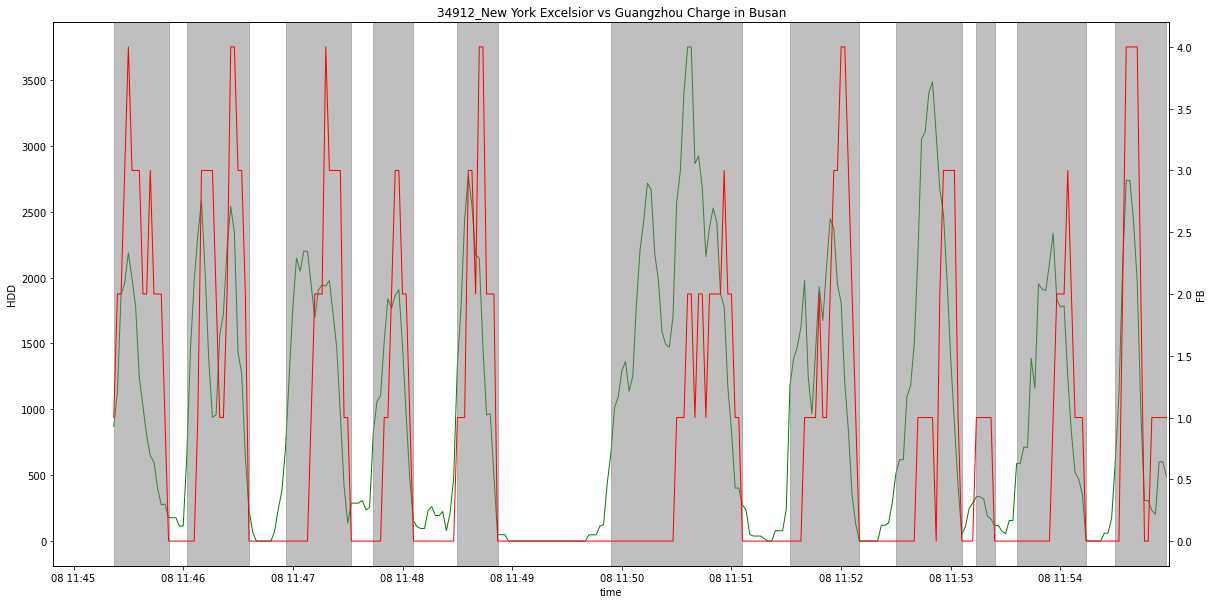

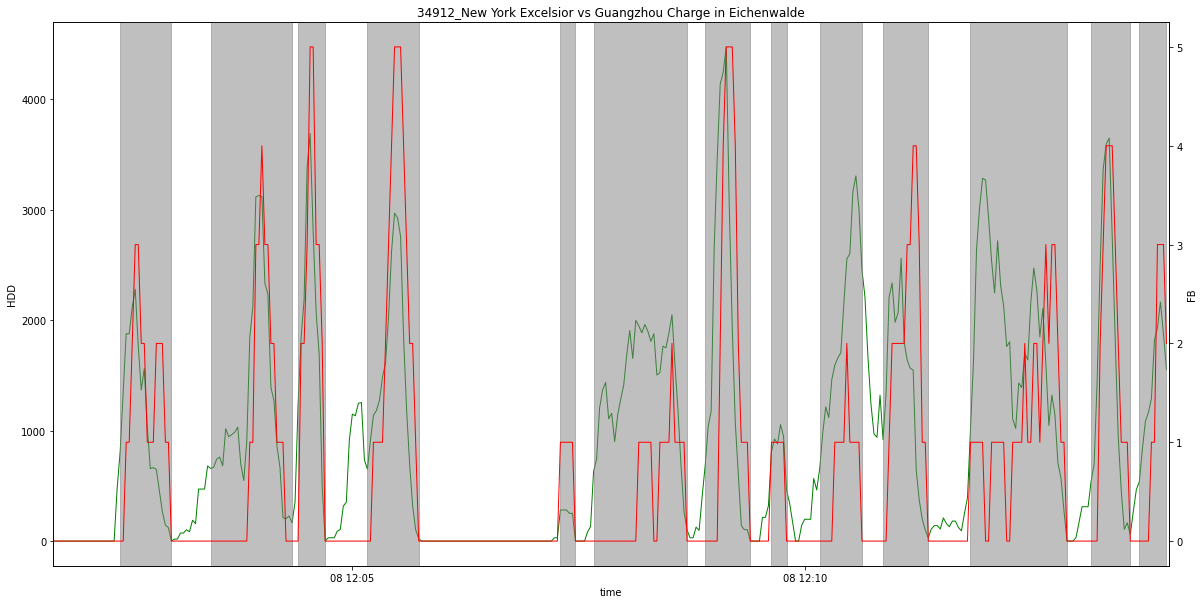

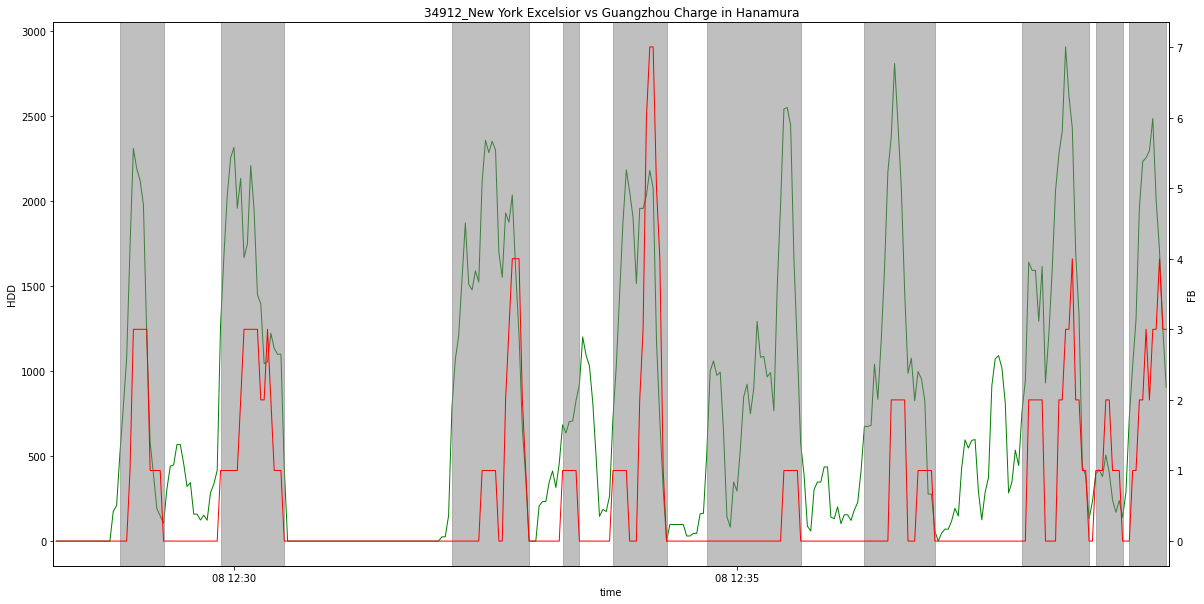

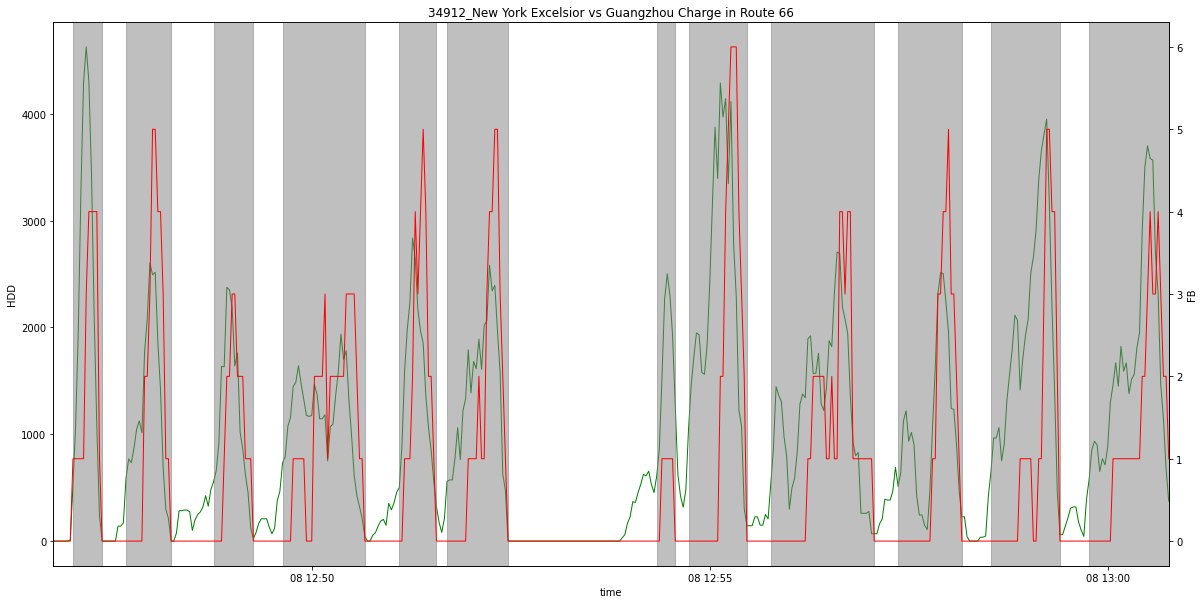

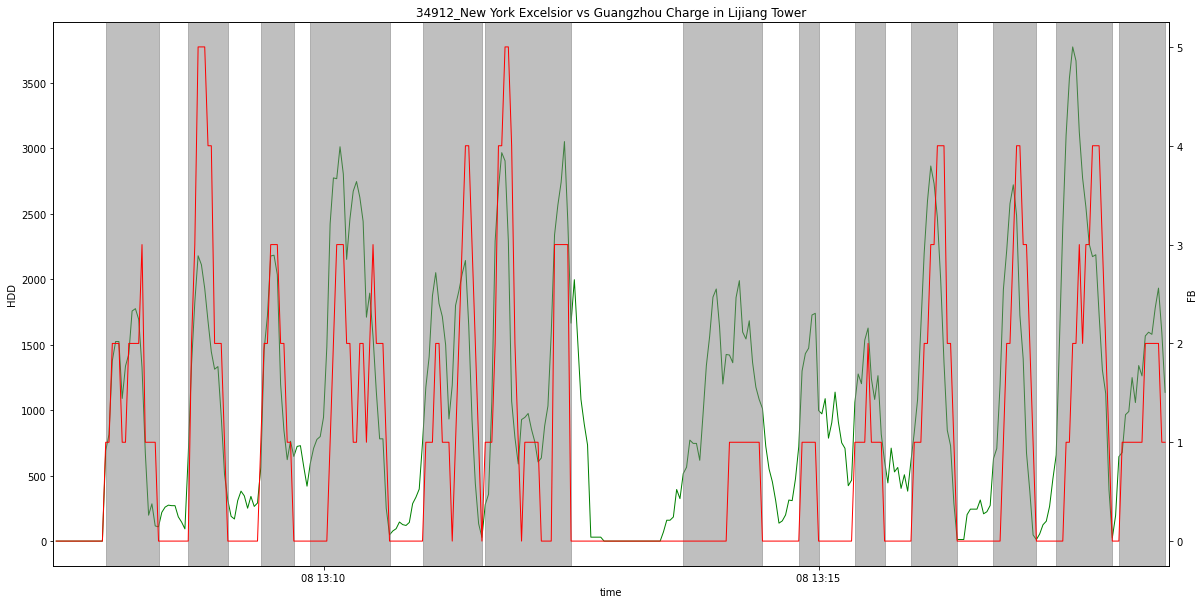

In [15]:
match_ids = get_esports_match_ids(team_name='New York Excelsior', opponent_name='Guangzhou Charge', winner='New York Excelsior', season=2020)
print(match_ids)

df_ = get_teamfight_info(34912, plotting=True)

In [16]:
# output에 한타 승리팀 column 추가

df_

,TF_start_datetime,TF_end_datetime,esports_match_id,map_name,map_order,TF_order_list,TF_winner_list,TF_TPB_sum
0,2020-08-08 11:45:22+00:00,2020-08-08 11:45:52+00:00,34912,Busan,1,1,Guangzhou Charge,-698.0
1,2020-08-08 11:46:02+00:00,2020-08-08 11:46:36+00:00,34912,Busan,1,2,New York Excelsior,526.0
2,2020-08-08 11:46:56+00:00,2020-08-08 11:47:32+00:00,34912,Busan,1,3,Guangzhou Charge,-1093.0
3,2020-08-08 11:47:44+00:00,2020-08-08 11:48:06+00:00,34912,Busan,1,4,New York Excelsior,582.0
4,2020-08-08 11:48:30+00:00,2020-08-08 11:48:52+00:00,34912,Busan,1,5,New York Excelsior,1115.0
5,2020-08-08 11:49:54+00:00,2020-08-08 11:51:06+00:00,34912,Busan,1,6,Guangzhou Charge,-1010.0
6,2020-08-08 11:51:32+00:00,2020-08-08 11:52:10+00:00,34912,Busan,1,7,Guangzhou Charge,-1105.0
7,2020-08-08 11:52:30+00:00,2020-08-08 11:53:06+00:00,34912,Busan,1,8,New York Excelsior,423.0
8,2020-08-08 11:53:14+00:00,2020-08-08 11:53:24+00:00,34912,Busan,1,9,New York Excelsior,253.0
9,2020-08-08 11:53:36+00:00,2020-08-08 11:54:14+00:00,34912,Busan,1,10,New York Excelsior,645.0


## SSG dict

In [17]:
tf_def_ssg_dict = {'Final |Rpl {0}:Blow:Blows;':44, 'All Damage Done':201, 'Time Played':38, 'Healing Done':465, 'Damage Blocked':675, '|Rpl {0}:Ultimate:Ultimates; Earned':1124, '|Rpl {0}:Ultimate:Ultimates; Used':1125, '|Rpl {0}:Shot:Shots; Fired':1132, 'Hero Damage Done':1208, '|Rpl {0}:Death:Deaths;':41}
tf_def_ssg_dict.values()

dict_values([44, 201, 38, 465, 675, 1124, 1125, 1132, 1208, 41])